In [1]:
import pandas as pd
import numpy as np
from scaling import standardize, normalize
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

from RandomForest import evaluate_rfc, create_roc_curve

from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.pipeline import make_pipeline

The goal is to test several supervised ML algorithms that may be suitable for our problem. The one with best performance is chosen for further investigation.

In [2]:

df2015 = pd.read_csv('../data/kaasa/kaasa_2015.csv', index_col=None, header=0)
df2016 = pd.read_csv('../data/kaasa/kaasa_2016.csv', index_col=None, header=0)
df2017 = pd.read_csv('../data/kaasa/kaasa_2017.csv', index_col=None, header=0)
df2018 = pd.read_csv('../data/kaasa/kaasa_2018.csv', index_col=None, header=0)
df2019 = pd.read_csv('../data/kaasa/kaasa_2019.csv', index_col=None, header=0)
df2020 = pd.read_csv('../data/kaasa/kaasa_2020.csv', index_col=None, header=0)
df2021 = pd.read_csv('../data/kaasa/kaasa_2021.csv', index_col=None, header=0)

all_files = [df2015, df2016, df2017, df2018, df2019, df2020, df2021]

df = pd.concat(all_files, axis=0, ignore_index=True)

untouched_df = pd.concat(all_files, axis=0, ignore_index=True)

In [3]:
df = df.drop(columns=['source_id', 'individual', 'owner_id', 'name',  'distance', 'sin_time', 'cos_time', 'date_time',
                      'longitude', 'latitude', 'temperature', 'altitude'])

df = standardize(df, ['velocity', 'angle']) # standarize the data
df = normalize(df, ['velocity', 'angle'], 0, 1) # normalize the data

X = df.drop(['attack'], axis=1) # Features
y = df['attack'] # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('attack', axis=1), df['attack'], test_size=0.1, random_state=42, stratify=y)

# Random Forest

In [17]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=100, n_jobs=-1)

# Define the evaluation metrics
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score),
           'roc_auc': make_scorer(roc_auc_score)}

# Define the pipeline with SMOTE oversampling
pipeline = make_pipeline(SMOTE(random_state=42), rf)

# Perform 5-fold cross-validation and print the results
cv_results = cross_validate(pipeline, X_train, y_train, cv=5, scoring=scoring)
print("Random Forest Results:")
print("Accuracy: {:.2f} (+/- {:.2f})".format(cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std() * 2))
print("Precision: {:.2f} (+/- {:.2f})".format(cv_results['test_precision'].mean(), cv_results['test_precision'].std() * 2))
print("Recall: {:.2f} (+/- {:.2f})".format(cv_results['test_recall'].mean(), cv_results['test_recall'].std() * 2))
print("F1: {:.2f} (+/- {:.2f})".format(cv_results['test_f1'].mean(), cv_results['test_f1'].std() * 2))
print("ROC AUC: {:.2f} (+/- {:.2f})".format(cv_results['test_roc_auc'].mean(), cv_results['test_roc_auc'].std() * 2))


Random Forest Results:
Accuracy: 0.88 (+/- 0.01)
Precision: 0.01 (+/- 0.00)
Recall: 0.11 (+/- 0.02)
F1: 0.02 (+/- 0.00)
ROC AUC: 0.50 (+/- 0.01)


roc_auc_score for RandomForestClassifier:  0.5079117290588395
Best threshold: 1


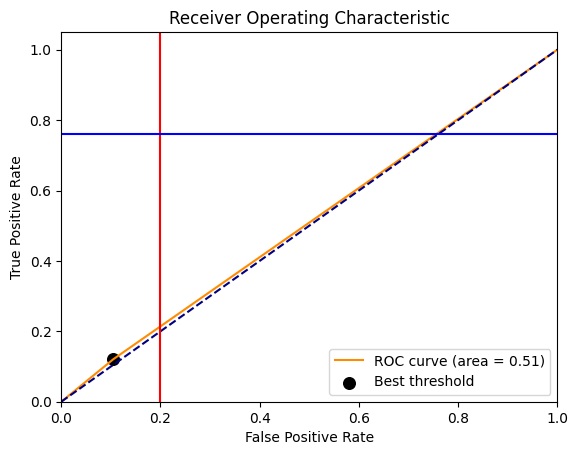

Accuracy: 88.39 %
[[21129  2482]
 [  298    41]]
              precision    recall  f1-score   support

           0      0.986     0.895     0.938     23611
           1      0.016     0.121     0.029       339

    accuracy                          0.884     23950
   macro avg      0.501     0.508     0.483     23950
weighted avg      0.972     0.884     0.925     23950



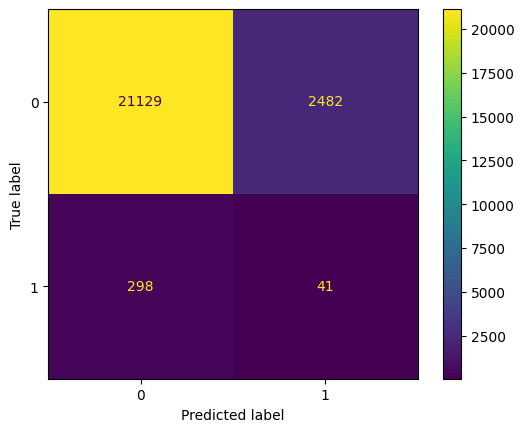

In [18]:
# Use SMOTE to oversample the minority class
oversample = SMOTE()
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train, y_train)

rf.fit(X_train_resampled, y_train_resampled)

y_pred = rf.predict(X_test)

create_roc_curve(y_test, y_pred)
evaluate_rfc(rf, y_test, y_pred)

# XGBoost

In [12]:
from xgboost import XGBClassifier

# Create the classifier with XGBoost
xgb_model = XGBClassifier(random_state=42)

# Define the evaluation metrics
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score),
           'roc_auc': make_scorer(roc_auc_score)}

# Define the pipeline with SMOTE oversampling
pipeline = make_pipeline(SMOTE(random_state=42), xgb_model)

# Perform 5-fold cross-validation and print the results
cv_results = cross_validate(pipeline, X_train, y_train, cv=5, scoring=scoring)
print("XGBoost Results:")
print("Accuracy: {:.2f} (+/- {:.2f})".format(cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std() * 2))
print("Precision: {:.2f} (+/- {:.2f})".format(cv_results['test_precision'].mean(), cv_results['test_precision'].std() * 2))
print("Recall: {:.2f} (+/- {:.2f})".format(cv_results['test_recall'].mean(), cv_results['test_recall'].std() * 2))


XGBoost Results:
Accuracy: 0.93 (+/- 0.01)
Precision: 0.01 (+/- 0.00)
Recall: 0.05 (+/- 0.02)


roc_auc_score for RandomForestClassifier:  0.4995359270196669
Best threshold: 2


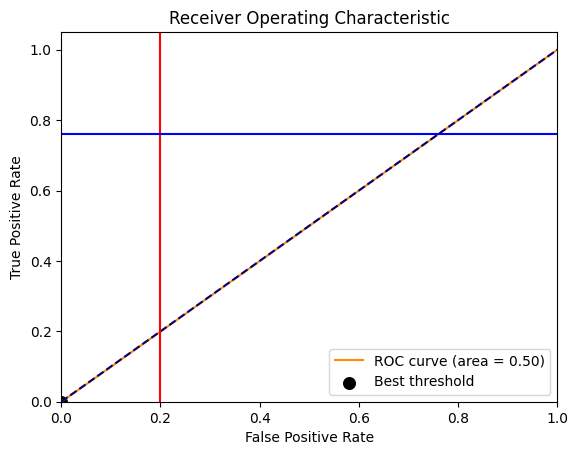

Accuracy: 94.48 %
[[22614   997]
 [  325    14]]
              precision    recall  f1-score   support

           0      0.986     0.958     0.972     23611
           1      0.014     0.041     0.021       339

    accuracy                          0.945     23950
   macro avg      0.500     0.500     0.496     23950
weighted avg      0.972     0.945     0.958     23950



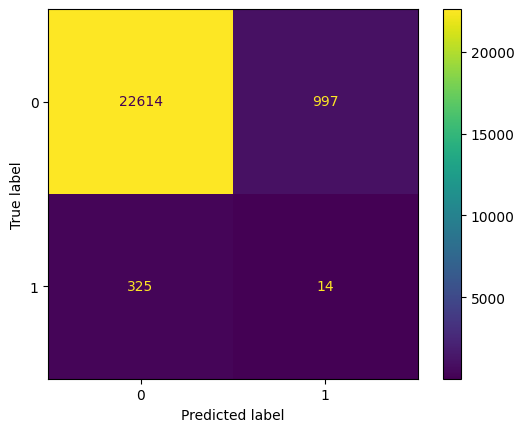

In [14]:
# Use SMOTE to oversample the minority class
oversample = SMOTE()
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train, y_train)

xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred = xgb_model.predict(X_test)

create_roc_curve(y_test, y_pred)
evaluate_rfc(xgb_model, y_test, y_pred)

# Logistic Regression 

In [4]:
from sklearn.linear_model import LogisticRegression

# Define the logistic regression model
logreg = LogisticRegression(random_state=42)

# Define the evaluation metrics
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score),
           'roc_auc': make_scorer(roc_auc_score)}

# Define the pipeline with SMOTE oversampling
pipeline = make_pipeline(SMOTE(), logreg)

# Perform 5-fold cross-validation and print the results
cv_results = cross_validate(pipeline, X_train, y_train, cv=5, scoring=scoring)
print("Logistic Regression Results:")
print("Accuracy: {:.2f} (+/- {:.2f})".format(cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std() * 2))
print("Precision: {:.2f} (+/- {:.2f})".format(cv_results['test_precision'].mean(), cv_results['test_precision'].std() * 2))
print("Recall: {:.2f} (+/- {:.2f})".format(cv_results['test_recall'].mean(), cv_results['test_recall'].std() * 2))
print("F1: {:.2f} (+/- {:.2f})".format(cv_results['test_f1'].mean(), cv_results['test_f1'].std() * 2))
print("ROC AUC: {:.2f} (+/- {:.2f})".format(cv_results['test_roc_auc'].mean(), cv_results['test_roc_auc'].std() * 2))

Logistic Regression Results:
Accuracy: 0.49 (+/- 0.01)
Precision: 0.02 (+/- 0.00)
Recall: 0.57 (+/- 0.04)
F1: 0.03 (+/- 0.00)
ROC AUC: 0.53 (+/- 0.02)


roc_auc_score for RandomForestClassifier:  0.5305905864335769
Best threshold: 1


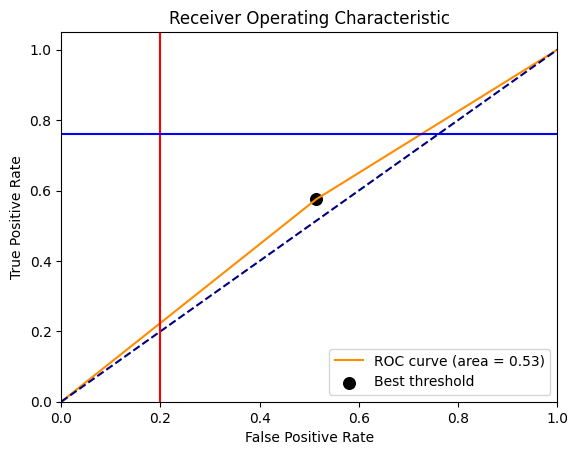

Accuracy: 48.72 %
[[11474 12137]
 [  144   195]]
              precision    recall  f1-score   support

           0      0.988     0.486     0.651     23611
           1      0.016     0.575     0.031       339

    accuracy                          0.487     23950
   macro avg      0.502     0.531     0.341     23950
weighted avg      0.974     0.487     0.643     23950



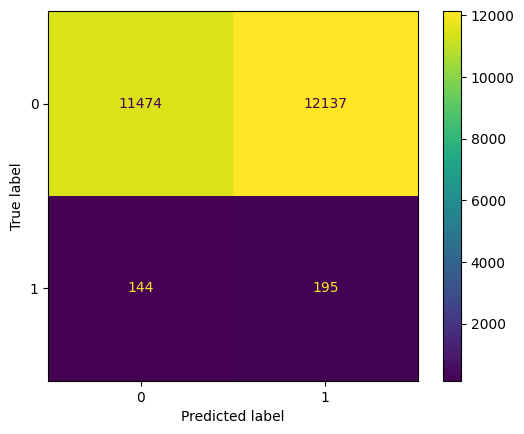

In [8]:
# Use SMOTE to oversample the minority class
oversample = SMOTE()
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train, y_train)

logreg.fit(X_train_resampled, y_train_resampled)
y_pred = logreg.predict(X_test)
create_roc_curve(y_test, y_pred)
evaluate_rfc(logreg, y_test, y_pred)

# Naive Bayes

In [19]:
from sklearn.naive_bayes import GaussianNB

# Define the logistic regression model
gnb = GaussianNB()

# Define the evaluation metrics
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score),
           'roc_auc': make_scorer(roc_auc_score)}

# Define the pipeline with SMOTE oversampling
pipeline = make_pipeline(SMOTE(), gnb)

# Perform 5-fold cross-validation and print the results
cv_results = cross_validate(pipeline, X_train, y_train, cv=5, scoring=scoring)
print("Naice Bayes Results:")
print("Accuracy: {:.2f} (+/- {:.2f})".format(cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std() * 2))
print("Precision: {:.2f} (+/- {:.2f})".format(cv_results['test_precision'].mean(), cv_results['test_precision'].std() * 2))
print("Recall: {:.2f} (+/- {:.2f})".format(cv_results['test_recall'].mean(), cv_results['test_recall'].std() * 2))
print("F1: {:.2f} (+/- {:.2f})".format(cv_results['test_f1'].mean(), cv_results['test_f1'].std() * 2))
print("ROC AUC: {:.2f} (+/- {:.2f})".format(cv_results['test_roc_auc'].mean(), cv_results['test_roc_auc'].std() * 2))

Naice Bayes Results:
Accuracy: 0.12 (+/- 0.00)
Precision: 0.01 (+/- 0.00)
Recall: 0.91 (+/- 0.02)
F1: 0.03 (+/- 0.00)
ROC AUC: 0.51 (+/- 0.01)


roc_auc_score for RandomForestClassifier:  0.5052927682699766
Best threshold: 1


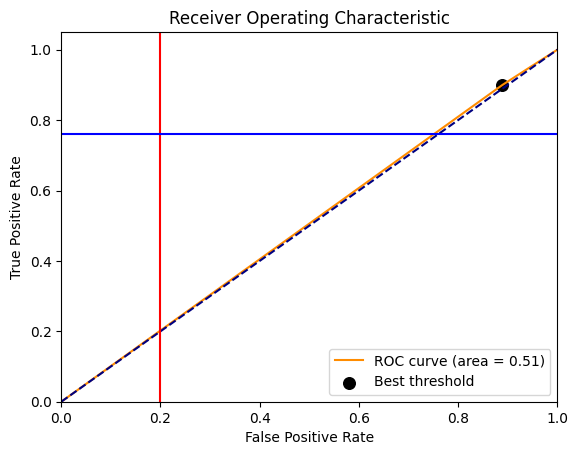

Accuracy: 12.2 %
[[ 2618 20993]
 [   34   305]]
              precision    recall  f1-score   support

           0      0.987     0.111     0.199     23611
           1      0.014     0.900     0.028       339

    accuracy                          0.122     23950
   macro avg      0.501     0.505     0.114     23950
weighted avg      0.973     0.122     0.197     23950



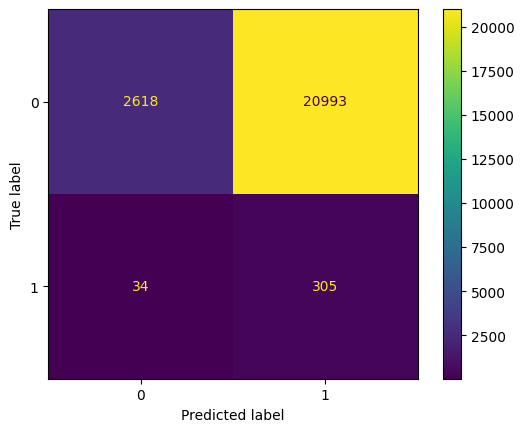

In [21]:
# Use SMOTE to oversample the minority class
oversample = SMOTE()
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train, y_train)

gnb.fit(X_train_resampled, y_train_resampled)
y_pred = gnb.predict(X_test)
create_roc_curve(y_test, y_pred)
evaluate_rfc(gnb, y_test, y_pred)

# K-Nearest Neighbors (KNN)

In [22]:
from sklearn.neighbors import KNeighborsClassifier

# Define the logistic regression model
knn = KNeighborsClassifier(n_neighbors=5)

# Define the evaluation metrics
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score),
           'roc_auc': make_scorer(roc_auc_score)}

# Define the pipeline with SMOTE oversampling
pipeline = make_pipeline(SMOTE(), knn)

# Perform 5-fold cross-validation and print the results
cv_results = cross_validate(pipeline, X_train, y_train, cv=5, scoring=scoring)
print("KNN Results:")
print("Accuracy: {:.2f} (+/- {:.2f})".format(cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std() * 2))
print("Precision: {:.2f} (+/- {:.2f})".format(cv_results['test_precision'].mean(), cv_results['test_precision'].std() * 2))
print("Recall: {:.2f} (+/- {:.2f})".format(cv_results['test_recall'].mean(), cv_results['test_recall'].std() * 2))
print("F1: {:.2f} (+/- {:.2f})".format(cv_results['test_f1'].mean(), cv_results['test_f1'].std() * 2))
print("ROC AUC: {:.2f} (+/- {:.2f})".format(cv_results['test_roc_auc'].mean(), cv_results['test_roc_auc'].std() * 2))

Naice Bayes Results:
Accuracy: 0.74 (+/- 0.01)
Precision: 0.02 (+/- 0.00)
Recall: 0.28 (+/- 0.03)
F1: 0.03 (+/- 0.00)
ROC AUC: 0.51 (+/- 0.01)


roc_auc_score for RandomForestClassifier:  0.5047807825186226
Best threshold: 1


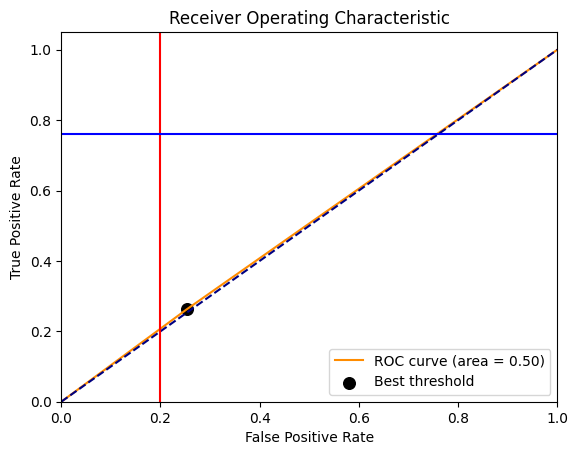

Accuracy: 74.02 %
[[17638  5973]
 [  250    89]]
              precision    recall  f1-score   support

           0      0.986     0.747     0.850     23611
           1      0.015     0.263     0.028       339

    accuracy                          0.740     23950
   macro avg      0.500     0.505     0.439     23950
weighted avg      0.972     0.740     0.838     23950



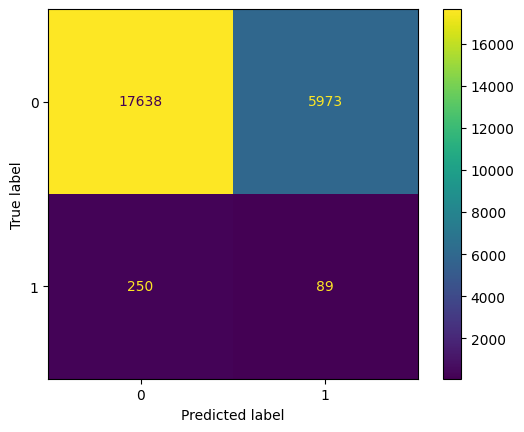

In [23]:
# Use SMOTE to oversample the minority class
oversample = SMOTE()
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train, y_train)

knn.fit(X_train_resampled, y_train_resampled)
y_pred = knn.predict(X_test)
create_roc_curve(y_test, y_pred)
evaluate_rfc(gnb, y_test, y_pred)

# Neural Networks

In [12]:
from sklearn.neural_network import MLPClassifier

# Define the logistic regression model
nn = MLPClassifier(hidden_layer_sizes=(10,), random_state=42)

# Define the evaluation metrics
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score),
           'roc_auc': make_scorer(roc_auc_score)}

# Define the pipeline with SMOTE oversampling
pipeline = make_pipeline(SMOTE(), nn)

# Perform 5-fold cross-validation and print the results
cv_results = cross_validate(pipeline, X_train, y_train, cv=5, scoring=scoring)
print("Neural Network Results:")
print("Accuracy: {:.2f} (+/- {:.2f})".format(cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std() * 2))
print("Precision: {:.2f} (+/- {:.2f})".format(cv_results['test_precision'].mean(), cv_results['test_precision'].std() * 2))
print("Recall: {:.2f} (+/- {:.2f})".format(cv_results['test_recall'].mean(), cv_results['test_recall'].std() * 2))
print("F1: {:.2f} (+/- {:.2f})".format(cv_results['test_f1'].mean(), cv_results['test_f1'].std() * 2))
print("ROC AUC: {:.2f} (+/- {:.2f})".format(cv_results['test_roc_auc'].mean(), cv_results['test_roc_auc'].std() * 2))

Naice Bayes Results:
Accuracy: 0.42 (+/- 0.11)
Precision: 0.02 (+/- 0.00)
Recall: 0.65 (+/- 0.14)
F1: 0.03 (+/- 0.00)
ROC AUC: 0.53 (+/- 0.02)


roc_auc_score for RandomForestClassifier:  0.5317749126731965
Best threshold: 1


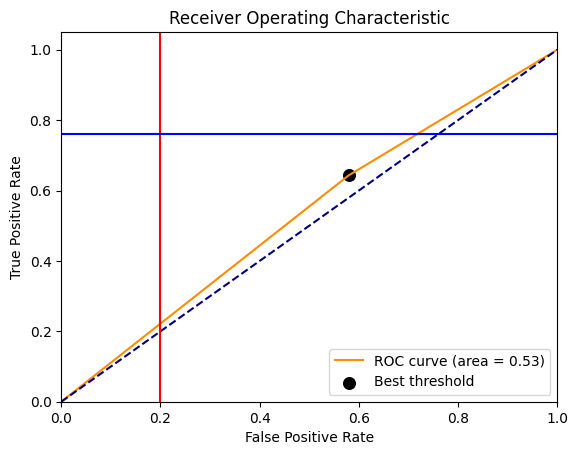

Accuracy: 42.36 %
[[ 9928 13683]
 [  121   218]]
              precision    recall  f1-score   support

           0      0.988     0.420     0.590     23611
           1      0.016     0.643     0.031       339

    accuracy                          0.424     23950
   macro avg      0.502     0.532     0.310     23950
weighted avg      0.974     0.424     0.582     23950



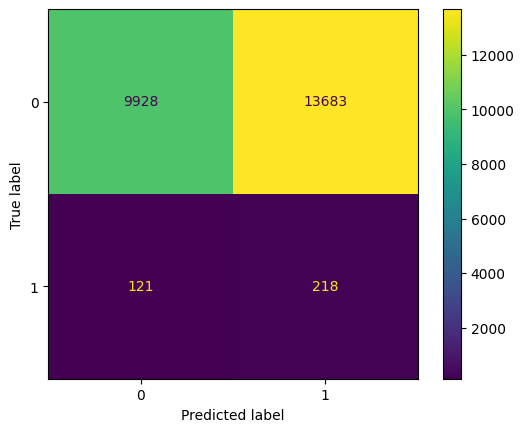

In [14]:
# Use SMOTE to oversample the minority class
oversample = SMOTE()
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train, y_train)

nn.fit(X_train_resampled, y_train_resampled)
y_pred = nn.predict(X_test)
create_roc_curve(y_test, y_pred)
evaluate_rfc(nn, y_test, y_pred)